# AASD 4015: Advanced Applied Mathematical Concepts for Deep Learning
## Project 2: "Aseptic Loose Hip Implant Detection on X-Ray Images"

## Students:
- Jose Lira (101426814)
- Tuo Xin (101409861)


## References

1. Haofan Wang, Zifan Wang, Piotr Mardziel. "Score-CAM: Score-Weighted Visual Explanations for Convolutional Neural Networks". Carnegie Mellon University
2. https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-scorecam-344a0456c48e
3. "Introduction to Deep Learning". Course: MIE1517 (Assignment 2), 2022. University of Toronto. 
4. Kaggle. Dataset: "Aseptic Loose Hip Implant X-Ray Database",  https://www.kaggle.com/datasets/tawsifurrahman/aseptic-loose-hip-implant-xray-database 


# Problem Statement


A classification model on detecting if the hip is loosening on X-Ray images is built in this project. What we try to explore from the deep learning perspective are the followings.

1. As recommanded by Chollet (Deep Learning with Python, P257) that we should fine-tune model with batch normalization layers frozen, we explore the influence of setting those layers unfreeze on the fine-tuned model result. It is believed that updatting internal mean and variance will interfere with the very small updates applied to the surrounding Conv layers.

2. Deep learning models are seen as black boxes, but there is stronger neeed on better interpretability for models to be implemented in some industries like the healthcare industry. Only if the model is demystified that they are allowed to be used in hospitals. Thus, we implemented a particular flavour of Class Activation Map (CAM) in this project to see if the model can learn to look at the correct place in the image to make the prediction, instead of just shooting in the dark and happened to get the prediction right. 

## Class Activation Maps (CAM)
- **CAM-Based** explanation provide visual explanation for a single input with a linear weighted combination of activation maps from convolutional layers. CAM creates localized visual explanations but is architecturesensitive, a global pooling layer is required to follow the convolutional layer of interest.
- **Grad-CAM** and its variations,e.g. Grad-CAM++ , intend to generalize CAM tomodels without global pooling layers and finally adopted widely in the community. 
- **Score-CAM** explanation method: the importance of activation maps are encoded by the global contribution of the corresponding input features instead of the local sensitivity measurement (a.k.a gradient information). **Score-CAM** gets rid of the dependence on gradients by obtaining the weight of each activation map through its forward passing score on target class, the final result is obtained by a linear combination of weights and activation
maps. The authors of [1] demonstrated that Score-CAM achieves better visual performance and fairness for interpreting the decision making process.


## Environment

- Windows 11
- Python 3.10.9
- PyTorch: torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
- VSCode 1.75.1
- CUDA: 11.6, V11.6.55
- CUDNN 11.6
- GPU: NVIDIA GeForce RTX 2060
- CPU: 06 Intel Core i7-10750 @2.6Ghz (12 CPUs, 32 GB RAM)

## Conclusions
1. Freezing all batch normalization layers does not show significant improvement from unfreezing all norm layers in denseblock 4. Furthur investigation can be done on the influence of unfreezing all norm layers, including norm layers in denseblock 1,2,3 and 4.

2. Class activation map shows the model learned correctly of looking at the correct place, where professional radiologiest looks at, to make a correct prediction. This helps pave the way of the model to be implemented in the real world.

## The Implementation:

### Loading the Libraries

In [54]:
from PIL import Image
import glob
from pathlib import Path
import os
import torch

### Load Dataset

In [55]:

# directory = '/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Data/Control'  # Replace with the path to your directory
# control_images_path = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]
# print(len(control_images_path))

directory = r'C:\Users\jlira\Training\__Classes_GeorgeBrown\4015 Advanced Mathematical Concepts for Deep LearningMachine Learning\Assignments\Project2\LooseHip-master\Data\Control'  # Replace with the path to your directory
control_images_path = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]
print(len(control_images_path))


94


In [56]:
# directory = '/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Data/Loose'  # Replace with the path to your directory
directory = './Data/Loose'  # Replace with the path to your directory

loose_images_path = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]

print(len(loose_images_path))

112


In [4]:
images_path = control_images_path + loose_images_path
labels = len(control_images_path) * [0] + len(loose_images_path) * [1] # binary classification: control is 0, loose is 1

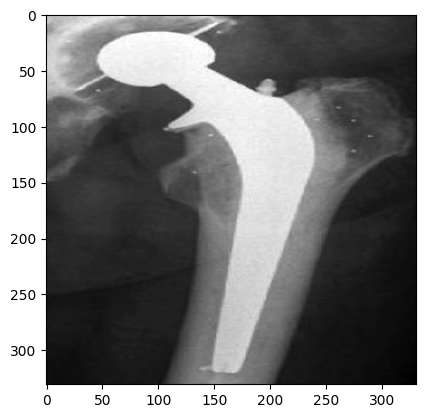

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(control_images_path[60])
imgplot = plt.imshow(img, cmap = 'gray')
plt.show()
# show a sample image from dataset

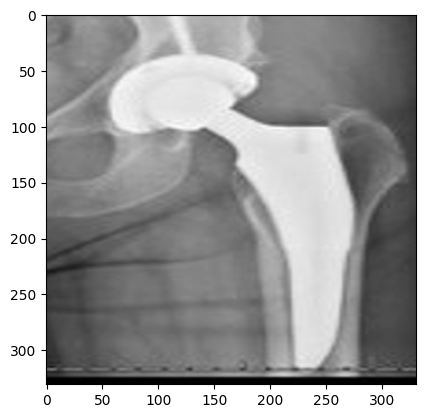

In [6]:
img = mpimg.imread(loose_images_path[9])
imgplot = plt.imshow(img, cmap = 'gray')
plt.show()
# show a sample image from dataset

In [7]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(images_path, labels, test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size = 0.8, random_state = 1) 

In [8]:
print(len(X_train))
print(len(y_test))
print(len(X_val))

131
42
33


In [9]:
#data augmentation: rotation, scaling, translation.

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Pre-processing

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
randomrotation = transforms.RandomRotation([-10,10])
resize = transforms.Resize((331,331))
scale_and_translation = transforms.RandomAffine(0,(0.05,0.05), (1,1.1))

preprocess = transforms.Compose([  
    randomrotation,
    scale_and_translation,
    resize,
    transforms.ToTensor(),
    normalize,
    ])

preprocess_test = transforms.Compose([  
    resize,
    transforms.ToTensor(),
    normalize,
    ])

### Define Model Structure


DenseNet mainly consists of 4 denseblocks, each denseblock has a dozen of denselayers, and each denselayer has 2 conv layers and 2 batch norm layers. 

In [11]:

import torch
import torchvision.models

DenseNet = torchvision.models.densenet121(pretrained=True)

c:\Users\jlira\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jlira\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
DenseNet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
for param in DenseNet.parameters():
    param.reqires_grad = False

for param in DenseNet.features.denseblock4.parameters():
    param.reqires_grad = True

for normlayer in [DenseNet.features.denseblock4.denselayer1.norm1, DenseNet.features.denseblock4.denselayer1.norm2,
          DenseNet.features.denseblock4.denselayer2.norm1, DenseNet.features.denseblock4.denselayer2.norm2,
          DenseNet.features.denseblock4.denselayer3.norm1, DenseNet.features.denseblock4.denselayer3.norm2,
          DenseNet.features.denseblock4.denselayer4.norm1, DenseNet.features.denseblock4.denselayer4.norm2,
          DenseNet.features.denseblock4.denselayer5.norm1, DenseNet.features.denseblock4.denselayer5.norm2,
          DenseNet.features.denseblock4.denselayer6.norm1, DenseNet.features.denseblock4.denselayer6.norm2,
          DenseNet.features.denseblock4.denselayer7.norm1, DenseNet.features.denseblock4.denselayer7.norm2,
          DenseNet.features.denseblock4.denselayer8.norm1, DenseNet.features.denseblock4.denselayer8.norm2,
          DenseNet.features.denseblock4.denselayer9.norm1, DenseNet.features.denseblock4.denselayer9.norm2,
          DenseNet.features.denseblock4.denselayer10.norm1, DenseNet.features.denseblock4.denselayer10.norm2,
          DenseNet.features.denseblock4.denselayer11.norm1, DenseNet.features.denseblock4.denselayer11.norm2,
          DenseNet.features.denseblock4.denselayer12.norm1, DenseNet.features.denseblock4.denselayer12.norm2,
          DenseNet.features.denseblock4.denselayer13.norm1, DenseNet.features.denseblock4.denselayer13.norm2,
          DenseNet.features.denseblock4.denselayer14.norm1, DenseNet.features.denseblock4.denselayer14.norm2,
          DenseNet.features.denseblock4.denselayer15.norm1, DenseNet.features.denseblock4.denselayer15.norm2,
          DenseNet.features.denseblock4.denselayer16.norm1, DenseNet.features.denseblock4.denselayer16.norm2]:
    for param in normlayer.parameters():
        param.requires_grad = False

# Based on Chellot's Book, freeze all batch norm layers

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Modified_DenseNet(nn.Module):
    def __init__(self):
        super(Modified_DenseNet, self).__init__()
        self.name = 'Modified_DenseNet'
        self.features = nn.Sequential(*list(DenseNet.features)[:-1])
        self.linear1 = nn.Linear(1024*10*10, 1024)
        self.linear2 = nn.Linear(1024, 10)
        self.linear3 = nn.Linear(10,1)
    
    def forward(self, x):
        x = self.features(x).view(-1,1024*10*10)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        

        return x

### Training

In [15]:
def get_data_loader(paths, labels, batch_size, train = False):

    def default_loader(paths, train = False):
      img_pil =  Image.open(paths).convert('RGB')
      if train:
        img_tensor = preprocess(img_pil)
      else:
        img_tensor = preprocess_test(img_pil)
      return img_tensor

    class dataset(Dataset):
        def __init__(self, loader=default_loader):
            self.images = paths
            self.target = labels
            self.loader = loader

        def __getitem__(self, index):
            fn = self.images[index]
            img = self.loader(fn)
            target = self.target[index]
            return img,target

        def __len__(self):
            return len(self.images)
    datasetloader = DataLoader(dataset(), batch_size= batch_size)
    return datasetloader

In [16]:

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    # path = '/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Model/' + str("model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
    #                                                batch_size,
    #                                                learning_rate,
    #                                                epoch))
    path = './LooseHip/Model/' + str("model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch))
    return path


def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #############################################
        #To Enable GPU Usage
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            net = net.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)
        if torch.cuda.is_available():
          net.cuda()
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################    
        outputs = net(inputs)

        loss = criterion(outputs, labels.unsqueeze(1).float())
        for i in range(0, outputs.shape[0]):
           if outputs[i][0] > 0:
                outputs[i][0] = 1
           else:
                outputs[i][0] = 0
        corr = outputs != labels.unsqueeze(1)
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err)
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [17]:
import math

def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig

In [18]:
import numpy as np
def train_net(net, batch_size=16, learning_rate=0.01, num_epochs=30):
   
    torch.manual_seed(1000)

    train_data_loader = get_data_loader(X_train, y_train,batch_size,True)
    val_data_loader = get_data_loader(X_val, y_val,batch_size)

    ########################################################################

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    ########################################################################

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################

    for epoch in range(num_epochs):  
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_data_loader, 0):
            inputs, labels = data

            #############################################
            #To Enable GPU Usage
            if torch.backends.mps.is_available():

              device = torch.device("mps")
              net = net.to(device)
              inputs = inputs.to(device)
              labels = labels.to(device)
            if torch.cuda.is_available():
              net.cuda()
              inputs = inputs.cuda()
              labels = labels.cuda()


            optimizer.zero_grad()
            
            outputs = net(inputs)

            loss = criterion(outputs, 
                             labels.unsqueeze(1).float())

            loss.backward()
            optimizer.step()
            

            for i in range(0, outputs.shape[0]):
              if outputs[i][0] > 0:
                outputs[i][0] = 1
              else:
                outputs[i][0] = 0

            corr = outputs != labels.unsqueeze(1)
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_data_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))

        model_path = get_model_name(net.name, batch_size, learning_rate, epoch) + str('unfreezenormlayer')
        if epoch > 0:
          torch.save(net.state_dict(), model_path)
    print('Finished Training')


    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

turn batch size greater than 8 might not be safe (GPU out of memory)

In [19]:
train_net(Modified_DenseNet(), batch_size=6, learning_rate=0.000005, num_epochs=20)

Epoch 1: Train err: 0.5419847328244275, Train loss: 3.079095649719238 |Validation err: 0.48484848484848486, Validation loss: 1.384921928246816
Epoch 2: Train err: 0.06870229007633588, Train loss: 2.9459911465644835 |Validation err: 0.3333333333333333, Validation loss: 1.364704688390096
Epoch 3: Train err: 0.061068702290076333, Train loss: 2.7806891083717344 |Validation err: 0.3939393939393939, Validation loss: 1.334311306476593
Epoch 4: Train err: 0.03816793893129771, Train loss: 2.564949321746826 |Validation err: 0.3333333333333333, Validation loss: 1.3004758556683857
Epoch 5: Train err: 0.0, Train loss: 2.2843096554279327 |Validation err: 0.2727272727272727, Validation loss: 1.2550822695096333
Epoch 6: Train err: 0.0, Train loss: 1.9475788295269012 |Validation err: 0.2727272727272727, Validation loss: 1.2071485320727031
Epoch 7: Train err: 0.0, Train loss: 1.609282946586609 |Validation err: 0.24242424242424243, Validation loss: 1.1621949474016826
Epoch 8: Train err: 0.0, Train loss: 

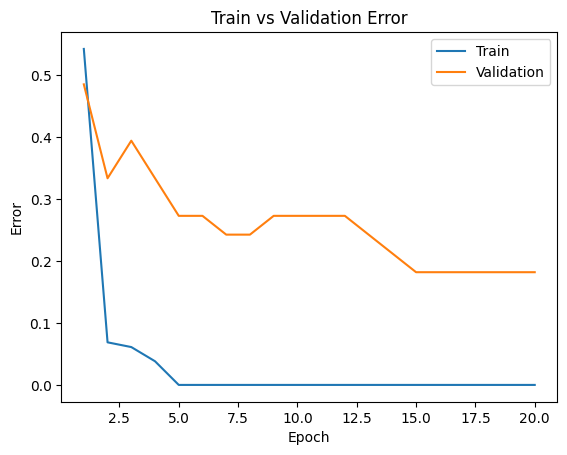

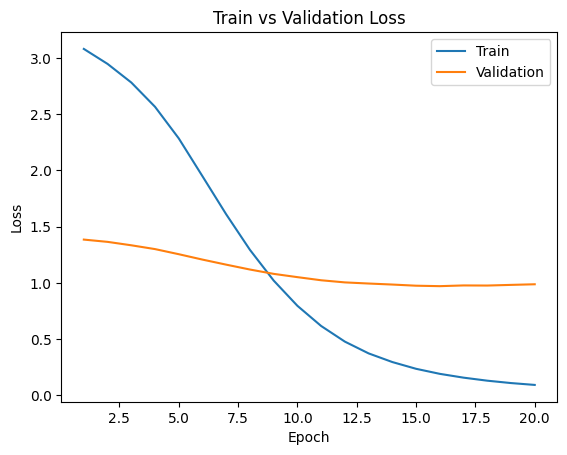

In [21]:
# modelpath = '/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Model/model_Modified_DenseNet_bs4_lr5e-06_epoch19'
modelpath = r'C:\Users\jlira\Training\__Classes_GeorgeBrown\4015 Advanced Mathematical Concepts for Deep LearningMachine Learning\Assignments\Project2\LooseHip-master\LooseHip\Model\model_Modified_DenseNet_bs6_lr5e-06_epoch19unfreezenormlayer'

plot_training_curve(modelpath)

### Experient: Unfreeze norm layers

In this experiment, we only unfreeze all norm layers in the last denseblock, denseblock 4. All norm layers in denblock 1-3 remains frozen.

In [22]:
for normlayer in [DenseNet.features.denseblock4.denselayer1.norm1, DenseNet.features.denseblock4.denselayer1.norm2,
          DenseNet.features.denseblock4.denselayer2.norm1, DenseNet.features.denseblock4.denselayer2.norm2,
          DenseNet.features.denseblock4.denselayer3.norm1, DenseNet.features.denseblock4.denselayer3.norm2,
          DenseNet.features.denseblock4.denselayer4.norm1, DenseNet.features.denseblock4.denselayer4.norm2,
          DenseNet.features.denseblock4.denselayer5.norm1, DenseNet.features.denseblock4.denselayer5.norm2,
          DenseNet.features.denseblock4.denselayer6.norm1, DenseNet.features.denseblock4.denselayer6.norm2,
          DenseNet.features.denseblock4.denselayer7.norm1, DenseNet.features.denseblock4.denselayer7.norm2,
          DenseNet.features.denseblock4.denselayer8.norm1, DenseNet.features.denseblock4.denselayer8.norm2,
          DenseNet.features.denseblock4.denselayer9.norm1, DenseNet.features.denseblock4.denselayer9.norm2,
          DenseNet.features.denseblock4.denselayer10.norm1, DenseNet.features.denseblock4.denselayer10.norm2,
          DenseNet.features.denseblock4.denselayer11.norm1, DenseNet.features.denseblock4.denselayer11.norm2,
          DenseNet.features.denseblock4.denselayer12.norm1, DenseNet.features.denseblock4.denselayer12.norm2,
          DenseNet.features.denseblock4.denselayer13.norm1, DenseNet.features.denseblock4.denselayer13.norm2,
          DenseNet.features.denseblock4.denselayer14.norm1, DenseNet.features.denseblock4.denselayer14.norm2,
          DenseNet.features.denseblock4.denselayer15.norm1, DenseNet.features.denseblock4.denselayer15.norm2,
          DenseNet.features.denseblock4.denselayer16.norm1, DenseNet.features.denseblock4.denselayer16.norm2]:
    for param in normlayer.parameters():
        param.requires_grad = True

In [23]:
train_net(Modified_DenseNet(), batch_size=4, learning_rate=0.000005, num_epochs=20)

Epoch 1: Train err: 0.20610687022900764, Train loss: 6.771782735983531 |Validation err: 0.15151515151515152, Validation loss: 5.418702185153961
Epoch 2: Train err: 0.0, Train loss: 4.290902713934581 |Validation err: 0.15151515151515152, Validation loss: 4.650009125471115
Epoch 3: Train err: 0.0, Train loss: 2.4824862082799277 |Validation err: 0.15151515151515152, Validation loss: 4.305095821619034
Epoch 4: Train err: 0.0, Train loss: 1.415521298845609 |Validation err: 0.15151515151515152, Validation loss: 4.068541660904884
Epoch 5: Train err: 0.0, Train loss: 0.8421509973704815 |Validation err: 0.15151515151515152, Validation loss: 4.041408680379391
Epoch 6: Train err: 0.0, Train loss: 0.5409344490617514 |Validation err: 0.15151515151515152, Validation loss: 4.132648676633835
Epoch 7: Train err: 0.0, Train loss: 0.37014615163207054 |Validation err: 0.15151515151515152, Validation loss: 4.2622721046209335
Epoch 8: Train err: 0.0, Train loss: 0.26650620872775715 |Validation err: 0.151515

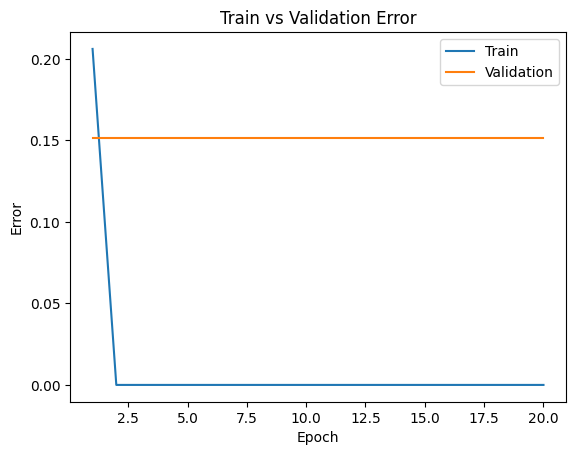

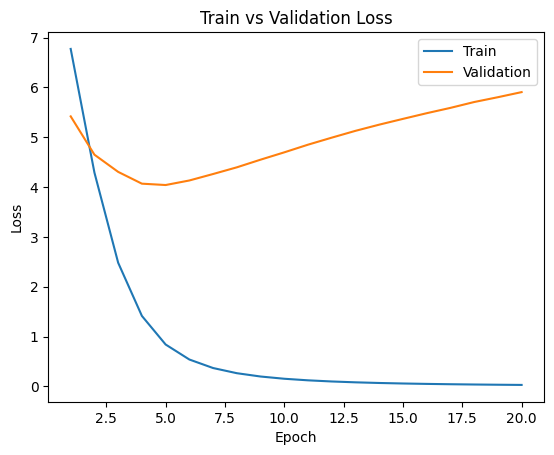

In [25]:

# plot_training_curve('/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Model/model_Modified_DenseNet_bs4_lr5e-06_epoch19unfreezenormlayer')
plot_training_curve(r'C:\Users\jlira\Training\__Classes_GeorgeBrown\4015 Advanced Mathematical Concepts for Deep LearningMachine Learning\Assignments\Project2\LooseHip-master\LooseHip\Model\model_Modified_DenseNet_bs4_lr5e-06_epoch19unfreezenormlayer')

### Model Evaluation

In [28]:
best_model = Modified_DenseNet()
# best_model.load_state_dict(torch.load('/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Model/model_Modified_DenseNet_bs4_lr5e-06_epoch16'))
best_model.load_state_dict(torch.load(r'C:\Users\jlira\Training\__Classes_GeorgeBrown\4015 Advanced Mathematical Concepts for Deep LearningMachine Learning\Assignments\Project2\LooseHip-master\LooseHip\Model\model_Modified_DenseNet_bs4_lr5e-06_epoch6unfreezenormlayer'))
best_model.eval()

Modified_DenseNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=

In [29]:
test_data_loader = get_data_loader(X_test, y_test, 1)

In [38]:
def test_set_pred_accuracy(best_model):
  correctpred = 0
  wrongpred = 0
  # device = torch.device("mps")
  device = torch.device("cuda")
  best_model = best_model.to(device)
  for testimage, label in test_data_loader:
    testimage = testimage.to(device)
    if best_model(testimage) > 0:
      pred = 1
    else:
      pred = 0
    if label == pred:
      correctpred += 1  
    else:
      wrongpred += 1
  return correctpred / (correctpred + wrongpred)

test_set_pred_accuracy(best_model)

0.8571428571428571

[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]
[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
[[15  5]
 [ 1 21]]


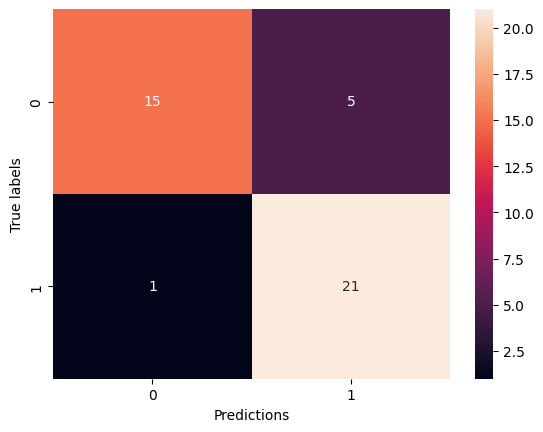

true no / pred no: TNR 0.9375
true yes/ pred yes: TPR 0.8076923076923077


In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_confusion_matrix(best_model):
  predictions = []
  labels = []
  # device = torch.device("mps")
  device = torch.device("cuda")

  best_model = best_model.to(device)
  for testimage, label in test_data_loader:
    if best_model(testimage.to(device)) > 0:
      pred = 1
    else:
      pred = 0
    predictions.append(pred)
    labels.append(int(label.item()))
  print(predictions)
  print(labels)
  M = confusion_matrix(labels, predictions)
  print(M)
  sns.heatmap(M, annot=True)
  plt.xlabel('Predictions')
  plt.ylabel('True labels')
  plt.show()
  print('true no / pred no: TNR', M[0][0]/(M[0][0] + M[1][0]))
  print('true yes/ pred yes: TPR', M[1][1]/(M[1][1] + M[0][1]))
  
get_confusion_matrix(best_model)

In [40]:
import numpy as np
import sklearn
from sklearn import metrics
def get_ROC_AUC(best_model):
  preds = []
  labels = []
  device = torch.device("cuda")
  # best_model = best_model.to(device)
  # best_model = best_model.cuda()
  for testimage, label in test_data_loader:
    pred = sigmoid(float(best_model(testimage.to(device)).cpu()))
    preds.append(pred)
    labels.append(int(label.item()))

  fpr, tpr, thresholds = metrics.roc_curve(labels, preds)
  metrics.auc(fpr,tpr)
  return fpr, tpr, thresholds,metrics.auc(fpr,tpr)



fpr, tpr, thresholds,auc = get_ROC_AUC(best_model)
auc

0.8704545454545455

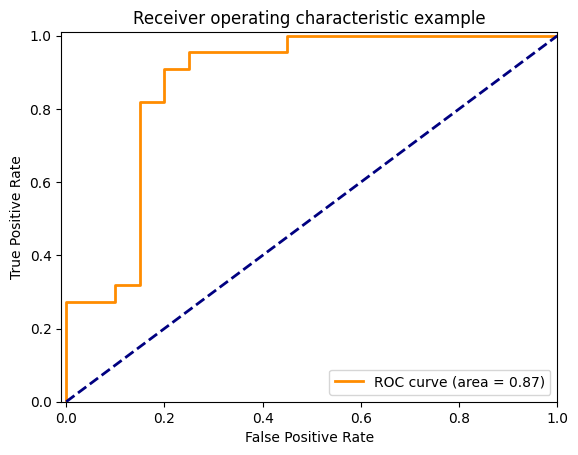

In [41]:
# Plot ROC curve and put AUC value into the legend

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [42]:
# implement ScoreCam

def upsample(input_width, input_height, image):
  image = resize(image,(input_width, input_height))
  return image

In [43]:
def image_description(sigmoidoutput, label):
  print('The true label of this image is {a}, the prediction is {b}'.format(a = 'Loose' if label == torch.tensor(1) else 'Normal', b = 'Loose' if sigmoidoutput >0.5 else 'Normal'))
  pred = torch.tensor(1) if sigmoidoutput >0.5 else torch.tensor(0)
  return pred

In [45]:
# device = 'mps'
device = 'cuda'
best_model_cuda = best_model.to(device)
Modified_DenseNet_features_cuda = Modified_DenseNet().features.to(device)
test_data_iter = iter(test_data_loader)
img_iter = iter(X_test)

## Generating Class Activation Map

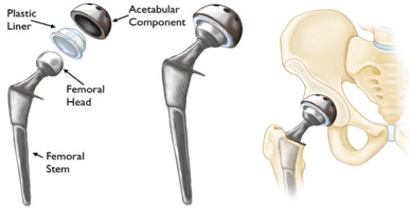

How to read X-ray iamges:
Although the detail standard of loosing hip is complicated and is realted to the hip replacement materials, comented or comentless, the general principles are:

1. radiolucent zone width is greater than 2mm.
2. Progressive lossening, even if the gap is smaller than 2mm.
3. Abnormal position of artifical components.

Long story short, the deep learning model should look at the gap between implant and femur and the gap between artifical acetabular component and pelvis.

In [46]:
from PIL import Image
import seaborn as sns
import cv2

def get_score_cam_plot(heatmap_untransparent = 0.7):
  """ Plots the original images, heatmaps and the hearmaps superimposed on original images based on the cv.colormap_hot

    Arg:
        heatmap_nontransparent: how non-transparent the heatmap is on the original image, range from 0 to 1
  """
  
  print('Show original image')
  img = mpimg.imread(next(img_iter))
  imgplot = plt.imshow(img, cmap = 'gray')
  plt.show()

  testimage, label = next(test_data_iter)
  pred = image_description(sigmoid(best_model(testimage.to(device))), label)


  activation_map = torch.nn.functional.interpolate(Modified_DenseNet_features_cuda(testimage.to(device)).unsqueeze(axis = 0), (1920, 331, 331))
  activation_map = activation_map.squeeze()

  normalized_activations = []
  class_score = []
  for i in range(activation_map.shape[0]):
    normalized_activation = (activation_map[i,:,:] - activation_map[i,:,:].min()) / (activation_map[i,:,:].max() - activation_map[i,:,:].min() + 1e-6)
    normalized_activations.append(normalized_activation)
    normalized_activation = normalized_activation.cpu().detach().numpy()
    input_2 = np.multiply(normalized_activation, testimage)
    class_score.append(sigmoid(best_model_cuda(input_2.to(device))))

  # if the true label is control, CAM shows where the model is looking at for predicting it as a control
  if pred == torch.tensor(0):
    class_score = list(1 - np.array(class_score))
  
  print('Show heatmap')
  CAM = []
  for i in range(activation_map.shape[0]):
    CAM.append(np.multiply(class_score[i], normalized_activations[i].cpu().detach().numpy()))

  Final_CAM = np.sum(np.array(CAM), axis = 0)
  Final_CAM = np.clip(np.array(Final_CAM), 0 , None)
  ax = sns.heatmap(Final_CAM, square = True)
  ax.tick_params(left=False, bottom=False)
  plt.show()

  print('Show superimposed colormap on original image')
  normalized_Final_CAM = (Final_CAM[:,:] - Final_CAM[:,:].min()) / (Final_CAM[:,:].max() - Final_CAM[:,:].min())
  normalized_Final_CAM = np.array(normalized_Final_CAM * 255, dtype = np.uint8)
  trycam = cv2.applyColorMap(normalized_Final_CAM, cv2.COLORMAP_HOT)
  trycam = trycam/255
  plt.imshow(img, cmap = 'gray')
  plt.imshow(normalized_Final_CAM, alpha = heatmap_untransparent)
  plt.show()

  #jet = plt.cm.get_cmap("jet")
  #jet_colors = jet(np.arange(256))[:, :3]
  #jet_heatmap = jet_colors[Final_CAM]
  #jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  #jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0])) 
  #jet_heatmap = keras.utils.img_to_array(jet_heatmap)
  #superimposed_img = jet_heatmap * 0.4 + img
  #superimposed_img = keras.utils.array_to_img(superimposed_img)
  #plt.imshow(superimposed_img)
  #plt.show()


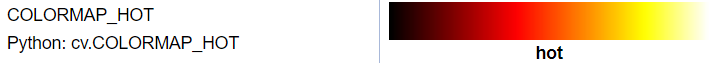

Show original image


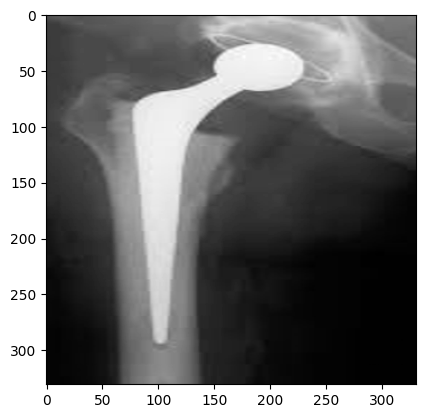

The true label of this image is Normal, the prediction is Normal
Show heatmap


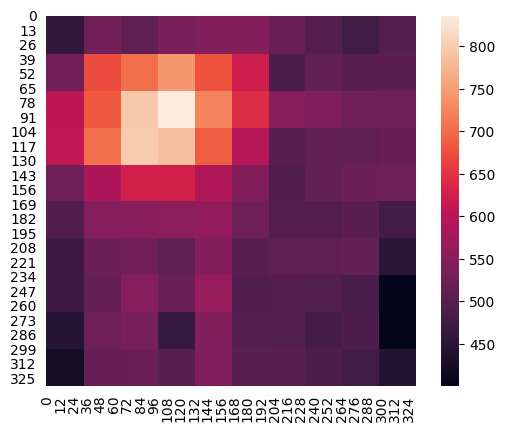

Show superimposed colormap on original image


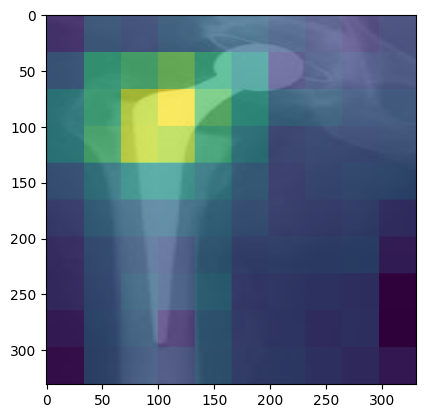

In [47]:
get_score_cam_plot(0.7)

Show original image


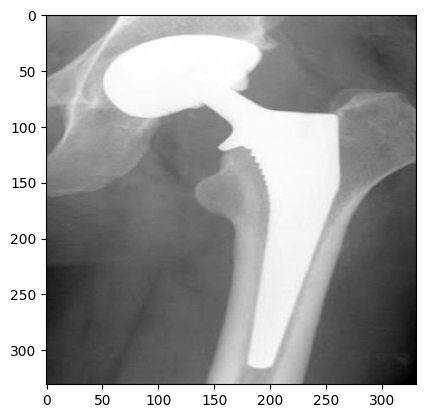

The true label of this image is Loose, the prediction is Loose
Show heatmap


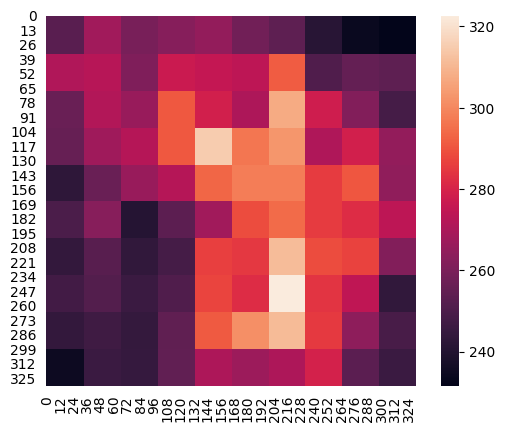

Show superimposed colormap on original image


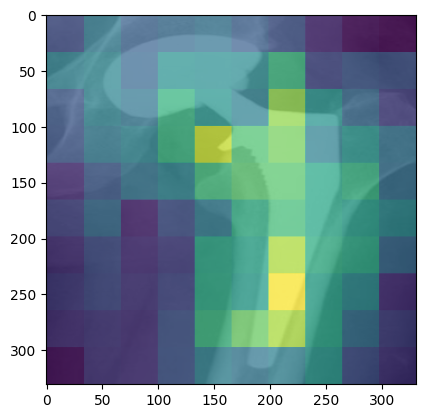

In [48]:
get_score_cam_plot(0.7)

Show original image


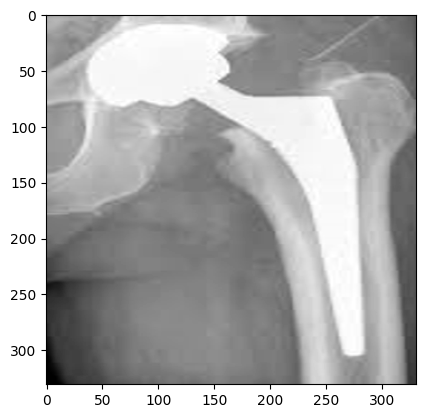

The true label of this image is Loose, the prediction is Loose
Show heatmap


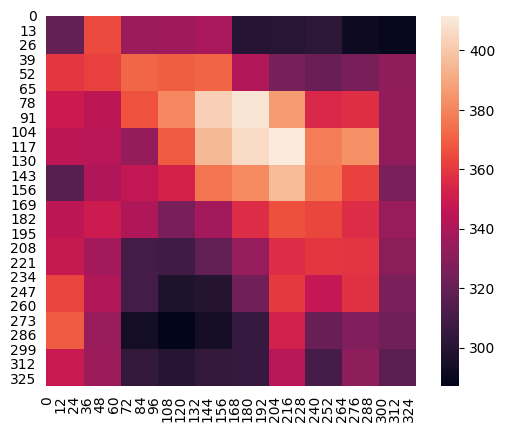

Show superimposed colormap on original image


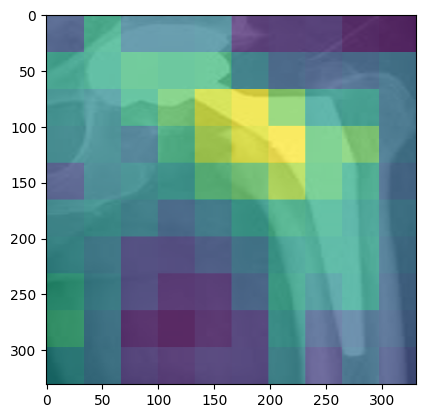

In [49]:
get_score_cam_plot(0.7)

Show original image


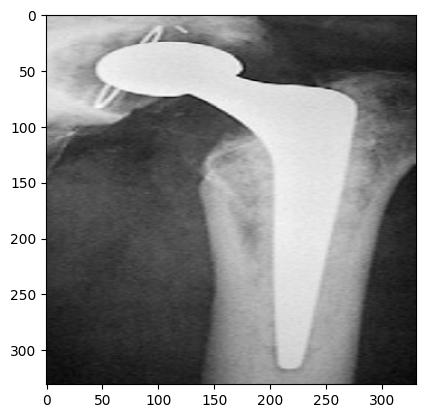

The true label of this image is Normal, the prediction is Normal
Show heatmap


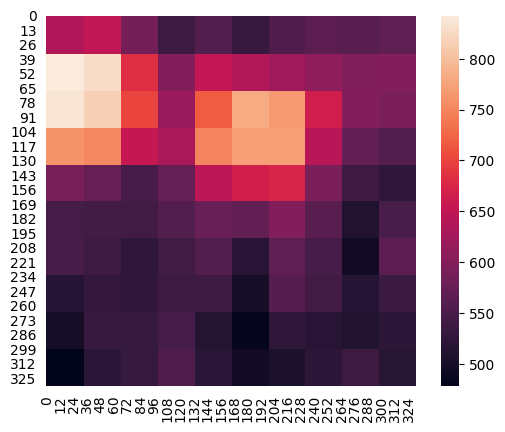

Show superimposed colormap on original image


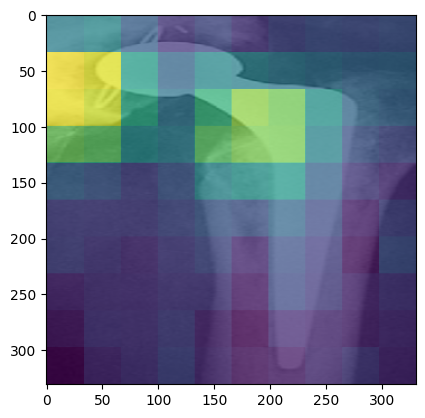

In [50]:
get_score_cam_plot(0.7)

Show original image


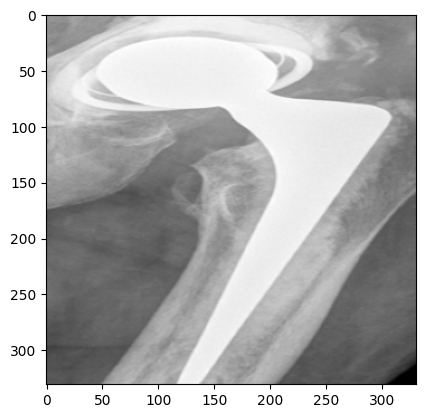

The true label of this image is Normal, the prediction is Loose
Show heatmap


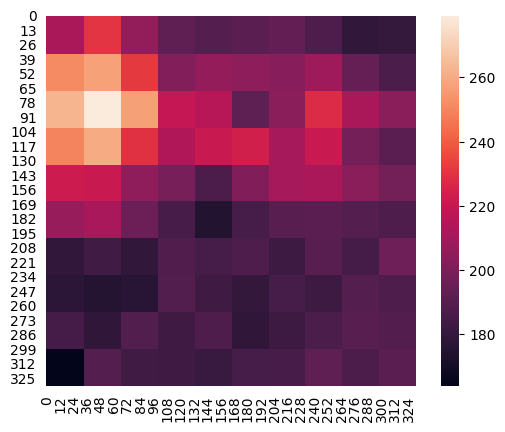

Show superimposed colormap on original image


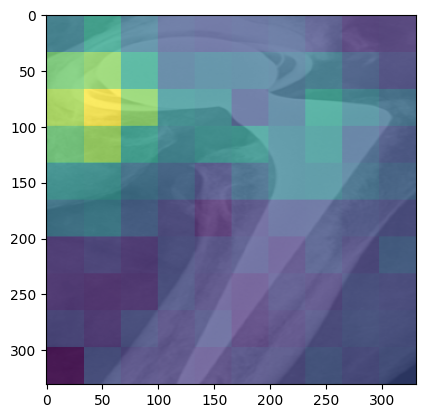

In [51]:
get_score_cam_plot(0.7)

Show original image


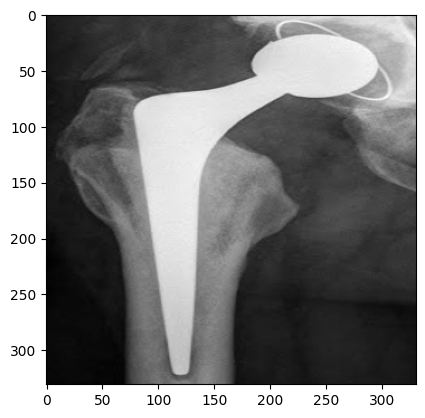

The true label of this image is Normal, the prediction is Normal
Show heatmap


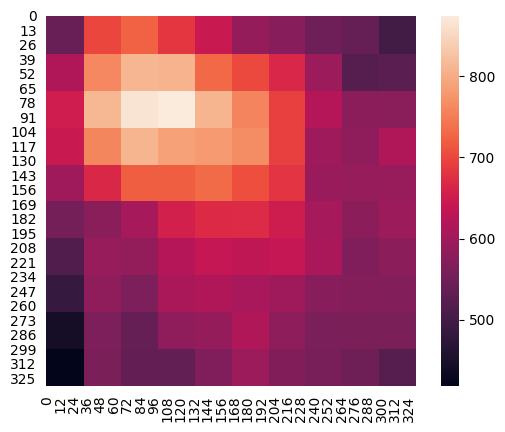

Show superimposed colormap on original image


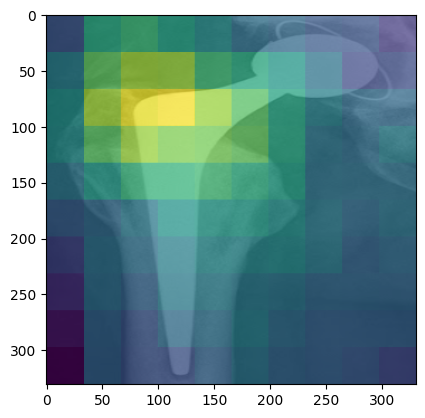

In [52]:
get_score_cam_plot(0.7)

Show original image


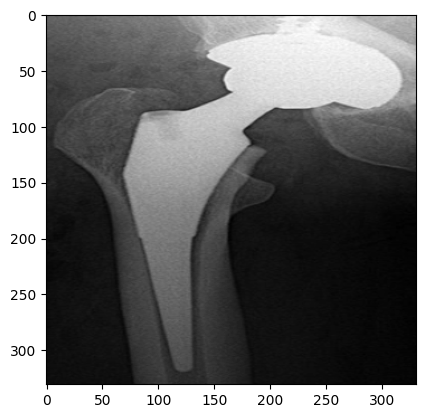

The true label of this image is Loose, the prediction is Loose
Show heatmap


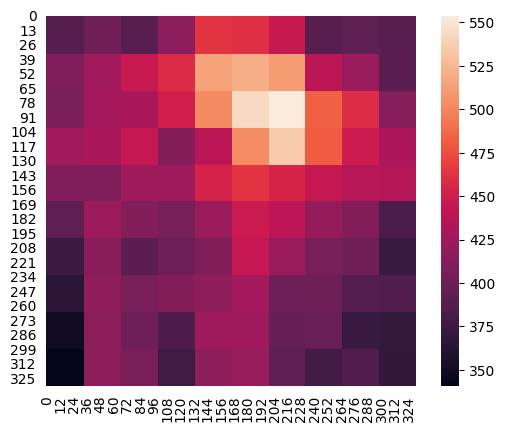

Show superimposed colormap on original image


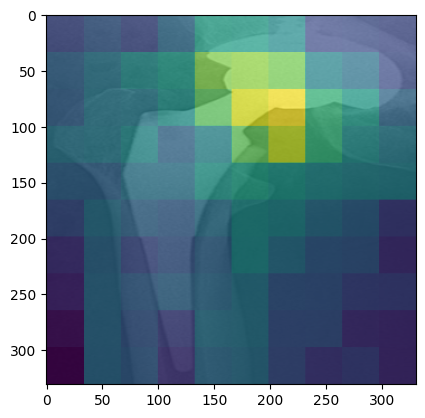

In [53]:
get_score_cam_plot(0.7)